# Autoencoders

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots

Notice, we are using Tensorflow Keras in this example to practice with it as so far we have been using PyTorch.

## 🚀 How an Autoencoder Works for Anomaly Detection 

## 📘 Meaning of $ \mathbb{E} $

In probability and statistics, $ \mathbb{E}[X] $ denotes the **expected value** (or **mean**) of a random variable $ X $.

It represents a **weighted average** of all possible values that $ X $ can take, where the weights are given by the probabilities associated with each value.

For a **discrete** random variable:

$$
\mathbb{E}[X] = \sum_{i} x_i \cdot P(X = x_i)
$$

For a **continuous** random variable:

$$
\mathbb{E}[X] = \int_{-\infty}^{\infty} x \cdot p(x) \, dx
$$

Where:
- $ P(X = x_i) $ is the probability mass function (PMF)
- $ p(x) $ is the probability density function (PDF)

Thus, $ \mathbb{E}[X] $ provides a measure of the **center** of the distribution of $ X $.


### 🧠 1. Training Phase

Let each input sample be a vector:

$$
\mathbf{x} \in \mathbb{R}^n
$$

The autoencoder consists of two components:

- **Encoder:** maps input $\mathbf{x}$ to latent representation $\mathbf{z}$

$$
\mathbf{z} = f(\mathbf{x}; \theta_1)
$$

- **Decoder:** reconstructs $\hat{\mathbf{x}}$ from $\mathbf{z}$

$$
\hat{\mathbf{x}} = g(\mathbf{z}; \theta_2) = g(f(\mathbf{x}; \theta_1); \theta_2)
$$

The goal is to minimize the **reconstruction loss**, usually Mean Squared Error (MSE):

$$
\mathcal{L}(\mathbf{x}, \hat{\mathbf{x}}) = \|\mathbf{x} - \hat{\mathbf{x}}\|^2 = \sum_{i=1}^{n} (x_i - \hat{x}_i)^2
$$

The model is trained by minimizing the expected loss:

$$
\min_{\theta_1, \theta_2} \ \mathbb{E}_{\mathbf{x}} \left[ \mathcal{L}(\mathbf{x}, g(f(\mathbf{x}))) \right]
$$

### 🔍 2. Inference Phase

At test time, for each new input $\mathbf{x}_{\text{test}}$:

- Compute reconstruction $\hat{\mathbf{x}}_{\text{test}} = g(f(\mathbf{x}_{\text{test}}))$
- Calculate reconstruction error:

$$
e = \|\mathbf{x}_{\text{test}} - \hat{\mathbf{x}}_{\text{test}}\|^2
$$

If $\mathbf{x}_{\text{test}}$ is **normal**, $e$ will be small. If it's **anomalous**, $e$ will be large because the model cannot represent unseen behavior.

### ⚠️ 3. Thresholding

We define a threshold $T$ for the reconstruction error to separate normal from anomalous behavior.

Common choices include:

- **Standard deviation rule:**

$$
T = \mu_e + k \cdot \sigma_e \quad \text{(e.g., } k = 2 \text{ or } 3 \text{)}
$$

where $\mu_e$ and $\sigma_e$ are the mean and standard deviation of training errors.

- **Quantile rule:**

$$
T = \text{quantile}(\{e_1, e_2, \dots, e_N\}, q)
$$

e.g., $q = 95\%$

- **Decision rule:**

$$
\text{If } e > T \text{, then flag } \mathbf{x}_{\text{test}} \text{ as an anomaly}
$$


### ✅ Summary

- The autoencoder learns a mapping:

$$
\mathbf{x} \rightarrow \hat{\mathbf{x}} \approx \mathbf{x}
$$

- It minimizes:

$$
\mathbb{E} \left[ \|\mathbf{x} - \hat{\mathbf{x}} \|^2 \right]
$$

- At inference, high reconstruction error indicates that the input diff


## Initial preparations

Set random seed for reproducibility

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

This function generates synthetic sensor data (normal and anomalous combined). It returns the full set of data and the places where the data is polluted with an anomaly.

In [4]:
def generate_sensor_data(n_samples=1000, anomaly_prob=0.01):
    # Normal data: sine wave with noise
    time = np.linspace(0, 100, n_samples)
    normal_data = np.sin(time) + np.random.normal(0, 0.1, n_samples)
    
    # Add anomalies: random spikes
    anomaly_indices = np.random.choice(n_samples, size=int(n_samples * anomaly_prob), replace=False)
    data = normal_data.copy()
    data[anomaly_indices] += np.random.normal(0, 1.5, len(anomaly_indices)) ## Pollute with excessive noise
    
    return data, anomaly_indices


This is a utility function for setting batches of data for the autoencoder. It creates sliding windows for a time-series `data` given a window size `window_size`.

In [5]:
def prepare_data(data, window_size=10):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
    return np.array(X)


# Build and train an autoencoder

This function construct a simple autoencoder using Keras

In [6]:
def build_autoencoder(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(input_dim, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

## Training
The AutoEncoder is trained exclusively on normal data. The training process involves adjusting the weights to minimize the reconstruction error.

In [7]:
# Parameters
n_samples = 3000
window_size = 30
epochs = 500
batch_size = 32
threshold_factor = 2

Let's create some data and get some anomalies embedded in it 

In [8]:
data, true_anomaly_indices = generate_sensor_data(n_samples)

Prepare training data (use normal data only). The AutoEncoder is trained exclusively on normal data so notice we replace the original data with sine waves not polluted with noise.


In [9]:
normal_data = data.copy()
normal_data[true_anomaly_indices] = np.sin(np.linspace(0, 100, n_samples))[true_anomaly_indices]  # Replace anomalies
X_train = prepare_data(normal_data, window_size)

Build and train autoencoder. The training process involves adjusting the weights to minimize the reconstruction error.

In [10]:
autoencoder = build_autoencoder(window_size)

from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,             # Stop if no improvement for 10 epochs
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train, X_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2721 - val_loss: 0.0582
Epoch 2/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0433 - val_loss: 0.0298
Epoch 3/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - val_loss: 0.0125
Epoch 4/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 5/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0104
Epoch 6/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 7/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 8/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097 - val_loss: 0.0100
Epoch 9/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.0099
Epoch 10/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0099
Epoch 11/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0098
Epoch 12/500
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

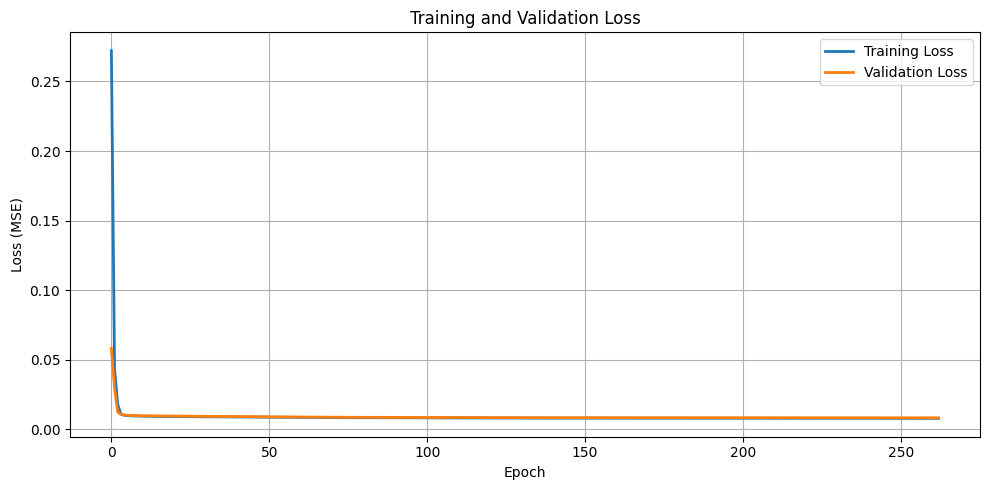

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Detect anomalies
We set a threshold for the reconstruction error. If the error surpasses this threshold, the data point is flagged as an anomaly.

In [12]:
def detect_anomalies(model, data, window_size, threshold_factor=2):
    # Prepare data
    X = prepare_data(data, window_size)
    
    # Get reconstruction errors
    reconstructions = model.predict(X)
    mse = np.mean(np.square(X - reconstructions), axis=1)
    
    # Set threshold based on mean + factor * std of errors
    threshold = np.mean(mse) + threshold_factor * np.std(mse)
    
    # Flag anomalies
    anomalies = mse > threshold
    anomaly_indices = np.where(anomalies)[0] + window_size  # Adjust for window offset
    
    return anomaly_indices, mse, threshold

Now we seek to detect the anomalies

In [13]:
anomaly_indices, mse, threshold = detect_anomalies(autoencoder, data, window_size, threshold_factor)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## Visualization

In [14]:
# Create subplot with 2 rows
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                    subplot_titles=("Sensor Data with Detected and True Anomalies", "Reconstruction Error"))

# Subplot 1: Sensor Data
fig.add_trace(go.Scatter(
    y=data,
    mode='lines',
    name='Sensor Data',
    line=dict(color='blue')
), row=1, col=1)

# Detected Anomalies (Red Circles)
fig.add_trace(go.Scatter(
    x=anomaly_indices,
    y=[data[i] for i in anomaly_indices],
    mode='markers',
    name='Detected Anomalies',
    marker=dict(color='red', size=8, symbol='circle')
), row=1, col=1)

# True Anomalies (Green X)
fig.add_trace(go.Scatter(
    x=true_anomaly_indices,
    y=[data[i] for i in true_anomaly_indices],
    mode='markers',
    name='True Anomalies',
    marker=dict(color='green', size=10, symbol='x')
), row=1, col=1)

# Subplot 2: Reconstruction Error
fig.add_trace(go.Scatter(
    y=mse,
    mode='lines',
    name='Reconstruction Error',
    line=dict(color='orange')
), row=2, col=1)

# Threshold line
fig.add_trace(go.Scatter(
    x=list(range(len(mse))),
    y=[threshold]*len(mse),
    mode='lines',
    name='Threshold',
    line=dict(color='red', dash='dash')
), row=2, col=1)

# Update layout
fig.update_layout(
    height=600,
    title='Anomaly Detection Results',
    showlegend=True
)

fig.show()
